# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.419704,False,-3.027045
1,-0.486053,False,0.015127
2,-0.978720,False,-1.740713
3,0.846745,True,6.350126
4,0.869623,True,4.968033
...,...,...,...
995,-0.909733,False,-1.472146
996,-1.447930,False,-0.536777
997,-2.143487,False,-3.795796
998,-1.321587,False,-0.719301


<AxesSubplot:xlabel='v0'>

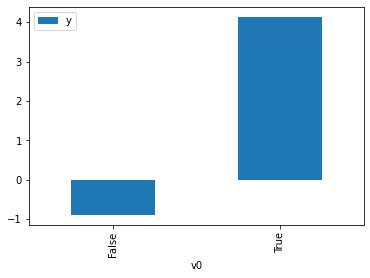

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

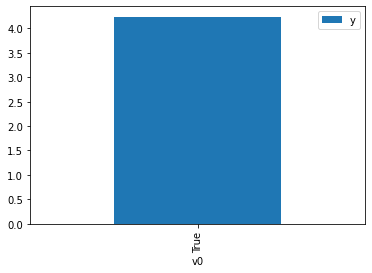

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.067776,False,0.376585,0.496331,2.014786
1,-0.693116,False,-0.572518,0.721742,1.385536
2,-0.327175,False,0.746571,0.619558,1.614055
3,-1.171717,False,-1.939843,0.826621,1.209744
4,0.125988,False,-0.392679,0.477835,2.092772
...,...,...,...,...,...
995,-0.383450,False,0.727767,0.636279,1.571638
996,-1.275157,False,-2.279855,0.844675,1.183887
997,-1.579396,False,0.114898,0.888984,1.124880
998,-0.400854,False,0.397264,0.641386,1.559123


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.309157,True,4.261877,0.149735,6.678453
1,-1.669790,True,3.999432,0.100166,9.983388
2,-0.953045,True,4.556999,0.216916,4.610084
3,-1.684925,True,2.678599,0.098444,10.158009
4,-2.900440,True,1.855275,0.022739,43.977344
...,...,...,...,...,...
995,-1.180375,True,3.846246,0.171807,5.820500
996,-1.287213,True,3.120002,0.153324,6.522156
997,-1.420642,True,4.739936,0.132564,7.543554
998,-1.381393,True,2.080298,0.138410,7.224907


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              4084.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:47:28   Log-Likelihood:                         -1433.3
No. Observations:                1000   AIC:                                      2871.
Df Residuals:                     998   BIC:                                      2880.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9528      0.024     40.489      0.000       0.907       0.999
x2             5.0218      0.060     83.179      0.000       4.903       5.140
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.551
Skew:                          -0.040   Prob(JB):                        0.759
Kurtosis:                       2.918   Cond. No.                         2.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""